# Введение в нейронные сети
## Урок 5. Рекуррентные нейронные сети

### Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

#### Попытка 1

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler

In [46]:
# список признаков, по которым будем учить
channelIndexes = [0,1, 2, 3]
#channelIndexes = [0,1,2]

# длина истории для работы
xLen = 14
# отступ тестов от тренировок
bias = 7

# шаг по данным для построения обучающих примеров
step = 1

# горизонт предсказания
future = 1


# параметры модели для обучения
batch_size = 8
epochs = 10

train_split_percents = 80

In [59]:
def data_get(path_to_csv, start_date, batch_size):
  df = pd.read_csv(path_to_csv, usecols=['<DATE>','<HIGH>','<LOW>'],
                   index_col=['<DATE>'], parse_dates=['<DATE>'],) #sep=';')
  df = df[df.index >= pd.to_datetime(start_date)]
  df["HLAvg"] = df['<HIGH>'].add(df['<LOW>']).div(2)
  del df['<HIGH>']
  del df['<LOW>']

  # Simple Moving Average
  df['MA'] = df['HLAvg'].rolling(window=14).mean()
  # Log Returns
  df['Returns'] = np.log(df['MA']/df['MA'].shift(1))
  
  df.dropna(how='any', inplace=True)

  return df

In [ ]:
df = data_get('./EURUSD_210101_220119_1D.csv', '01.01.2021', batch_size)
df.head()

,HLAvg,MA,Returns
<DATE>,,,
2021-01-18,1.206945,1.219707,-0.000845
2021-01-19,1.211000,1.218773,-0.000767
2021-01-20,1.211660,1.217652,-0.000920
2021-01-21,1.214010,1.216683,-0.000797
2021-01-22,1.216980,1.215704,-0.000804


In [ ]:
scaler = MinMaxScaler()
df[['HLAvg', 'MA', 'Returns']] = scaler.fit_transform(df[['HLAvg', 'MA', 'Returns']])
df.head()

,HLAvg,MA,Returns
<DATE>,,,
2021-01-18,0.834996,0.995170,0.362347
2021-01-19,0.874646,0.985033,0.381281
2021-01-20,0.881099,0.972883,0.344311
2021-01-21,0.904077,0.962366,0.374022
2021-01-22,0.933118,0.951757,0.372166


In [ ]:
def data_split_prepare(df, percent, bias, xLen, future, batch_size):
  channelIndexes = []
  for i in range(len(list(df.columns))):
    channelIndexes.append(i)
  train_split = round(len(df.iloc[:,0]) * percent / 100)
  train_data = df.iloc[0 : train_split , channelIndexes]
  val_data = df.iloc[train_split+bias:, channelIndexes]
  
  Chanel_numb = len(channelIndexes)

  start = xLen + future
  end = start + train_split-1

  xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
  xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
  yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

  sequence_length = int(xLen / step)

  x_end = len(val_data) - xLen - future

  label_start = len(train_data)+bias+xLen + future +1

  xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
  xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
  yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
      xTrain,
      yTrain,
      sequence_length=xLen,
      sampling_rate=1,
      batch_size=batch_size,
      )
  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
      xVal,
      yVal,
      sequence_length=xLen,
      sampling_rate=1,
      batch_size=batch_size,
      )
  
  return xTrain, xVal, yTrain, yVal, dataset_train, dataset_val


In [ ]:
X_train, X_val, y_train, y_val, model_train, model_val = data_split_prepare(df, train_split_percents, bias, xLen, future, batch_size)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((244, 3), (54, 3), (244,), (54,))

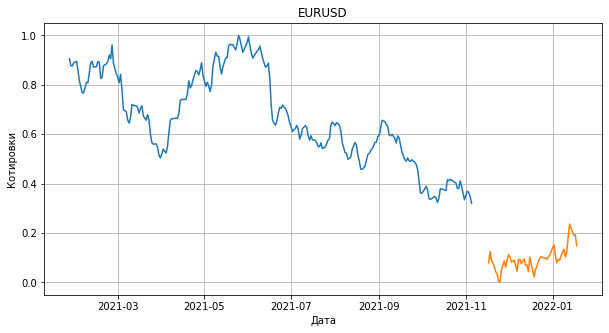

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df.index[xLen:y_train.shape[0]+xLen], y_train[:])
plt.plot(df.index[y_train.shape[0]+bias+future+2*xLen-1:],y_val[:])
plt.grid('on')
plt.xlabel('Дата')
plt.ylabel('Котировки')

plt.title('EURUSD')
plt.show()

In [ ]:
for batch in model_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (8, 7, 3)
Target shape: (8,)


In [ ]:
for batch in model_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (8, 7, 3)
Target shape: (8,)


In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    model_train,
    epochs=epochs,
    validation_data=model_val,
    callbacks=[callbaсk])

Epoch 1/10
30/30 [==============================] - 6s 46ms/step - loss: 0.0675 - mae: 0.1746 - val_loss: 0.0257 - val_mae: 0.1533
Epoch 2/10
30/30 [==============================] - 1s 17ms/step - loss: 0.0077 - mae: 0.0661 - val_loss: 0.0186 - val_mae: 0.1286
Epoch 3/10
30/30 [==============================] - 1s 18ms/step - loss: 0.0086 - mae: 0.0688 - val_loss: 0.0188 - val_mae: 0.1297
Epoch 4/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0089 - mae: 0.0694 - val_loss: 0.0181 - val_mae: 0.1266
Epoch 5/10
30/30 [==============================] - 1s 17ms/step - loss: 0.0083 - mae: 0.0676 - val_loss: 0.0170 - val_mae: 0.1224
Epoch 6/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0081 - mae: 0.0670 - val_loss: 0.0158 - val_mae: 0.1174
Epoch 7/10
30/30 [==============================] - 1s 17ms/step - loss: 0.0078 - mae: 0.0659 - val_loss: 0.0146 - val_mae: 0.1123
Epoch 8/10
30/30 [==============================] - 1s 21ms/step - loss: 0.0075 - m

In [ ]:
pred = model.predict(model_train).flatten()
predVal = model.predict(model_val).flatten()

In [ ]:
pred.shape, predVal.shape

((238,), (48,))

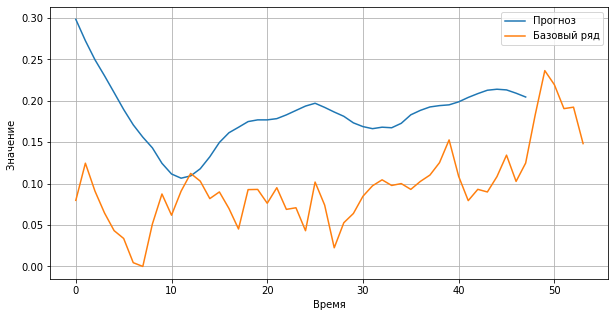

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[:], 
         label='Прогноз')
plt.plot(y_val.flatten()[:], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

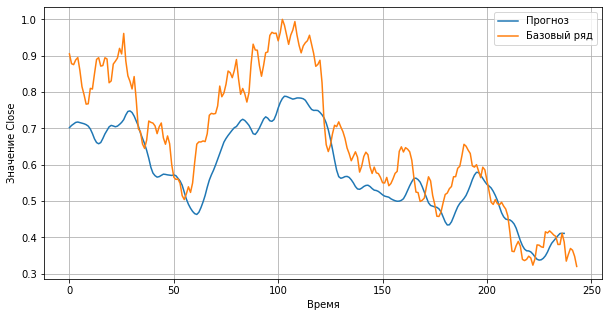

In [ ]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[:], 
         label='Прогноз')
plt.plot(y_train.flatten()[:], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Выводы:
- остановился в продолжении изучения данного опыта из-за явного/визуального отставания прогноза от имеющихся котировок;
- нет понимания почему прогноз заканчивается раньше котировок.

#### Попытка 2

In [ ]:
  df = pd.read_csv('./CHFUSD_210101_220118_1H.csv', usecols=['<DATE>', '<OPEN>', '<HIGH>','<LOW>', '<CLOSE>'],
                   index_col=['<DATE>'], parse_dates=['<DATE>'])
  df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>
<DATE>,,,,
2021-01-01,1.12930,1.13031,1.1291,1.1296
2021-01-01,1.12918,1.12980,1.1280,1.1298
2021-01-01,1.12960,1.12960,1.1296,1.1296
2021-01-01,1.12960,1.12960,1.1296,1.1296
2021-01-01,1.13120,1.13120,1.1298,1.1298


In [ ]:
df[['<OPEN>', '<HIGH>','<LOW>', '<CLOSE>']] = scaler.fit_transform(df[['<OPEN>', '<HIGH>','<LOW>', '<CLOSE>']])
df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>
<DATE>,,,,
2021-01-01,0.861810,0.865893,0.869104,0.863514
2021-01-01,0.860400,0.859851,0.856132,0.865861
2021-01-01,0.865335,0.857481,0.875000,0.863514
2021-01-01,0.865335,0.857481,0.875000,0.863514
2021-01-01,0.884136,0.876436,0.877358,0.865861


In [47]:
X_train, X_val, y_train, y_val, model_train, model_val = data_split_prepare(df, train_split_percents, bias, xLen, future, batch_size)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5435, 4), (1341, 4), (5435,), (1341,))

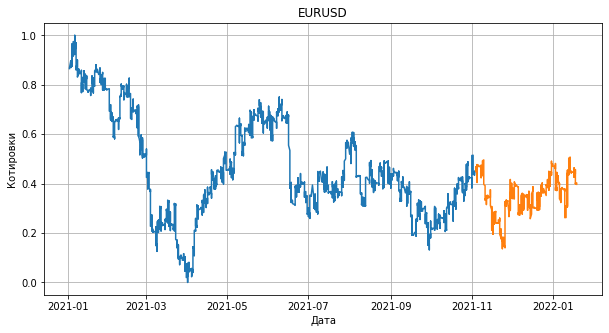

In [48]:
plt.figure(figsize=(10,5))
plt.plot(df.index[xLen:y_train.shape[0]+xLen], y_train[:])
plt.plot(df.index[y_train.shape[0]+bias+future+2*xLen-1:],y_val[:])
plt.grid('on')
plt.xlabel('Дата')
plt.ylabel('Котировки')

plt.title('EURUSD')
plt.show()

In [49]:
for batch in model_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (8, 14, 4)
Target shape: (8,)


In [50]:
for batch in model_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (8, 14, 4)
Target shape: (8,)


In [52]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    model_train,
    epochs=epochs,
    validation_data=model_val,
    callbacks=[callbaсk])

Epoch 1/10
678/678 [==============================] - 19s 23ms/step - loss: 0.0040 - mae: 0.0391 - val_loss: 0.0124 - val_mae: 0.1013
Epoch 2/10
678/678 [==============================] - 14s 21ms/step - loss: 0.0030 - mae: 0.0428 - val_loss: 0.0124 - val_mae: 0.1026
Epoch 3/10
678/678 [==============================] - 15s 22ms/step - loss: 0.0033 - mae: 0.0447 - val_loss: 0.0113 - val_mae: 0.0942
Epoch 4/10
678/678 [==============================] - 15s 22ms/step - loss: 0.0033 - mae: 0.0440 - val_loss: 0.0113 - val_mae: 0.0929
Epoch 5/10
678/678 [==============================] - 15s 22ms/step - loss: 0.0041 - mae: 0.0492 - val_loss: 0.0105 - val_mae: 0.0849
Epoch 6/10
678/678 [==============================] - 15s 22ms/step - loss: 0.0049 - mae: 0.0521 - val_loss: 0.0100 - val_mae: 0.0821
Epoch 7/10
678/678 [==============================] - 15s 22ms/step - loss: 0.0050 - mae: 0.0524 - val_loss: 0.0103 - val_mae: 0.0830
Epoch 8/10
678/678 [==============================] - 15s 22ms

In [53]:
pred = model.predict(model_train).flatten()
predVal = model.predict(model_val).flatten()

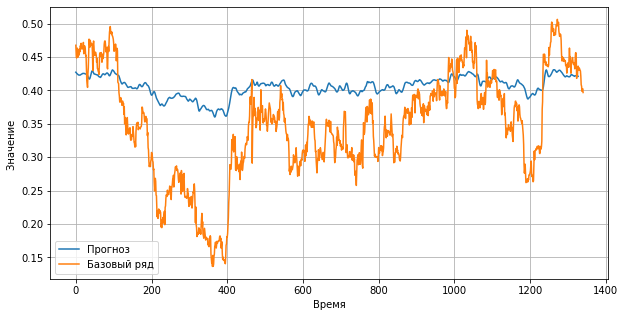

In [55]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[:], 
         label='Прогноз')
plt.plot(y_val.flatten()[:], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

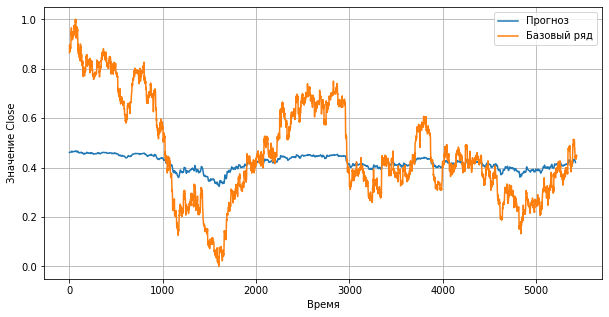

In [56]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[:], 
         label='Прогноз')
plt.plot(y_train.flatten()[:], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Выводы:
- нет точного понимания, что является таргетом для создаваемой модели;
- предположительно в попытке 1, для таргета использовался МА, в свою очередь для попытки 2 для таргета использовалась одна из котировок, что может позволить предположить, что MA прогнозируется лучше самой котировки.

#### Попытка 3

In [74]:
df = data_get('./CHFUSD_210101_220118_1H.csv', '01.01.2021', batch_size)
# Simple Moving Average
df['MA'] = df['HLAvg'].rolling(window=xLen).mean()
# Log Returns
df['Returns'] = np.log(df['MA']/df['MA'].shift(1))
df.dropna(how='any', inplace=True)
df = df[df.shape[0] % batch_size:]
validation_size = round(df.shape[0]*0.2)
test_size = round(df.shape[0]*0.2)
df_train = df[:- validation_size - test_size]
df_validation = df[- validation_size - test_size - xLen:- test_size]
df_test = df[- test_size - xLen:]
df_train.shape, df_validation.shape, df_test.shape

((4066, 3), (1369, 3), (1369, 3))

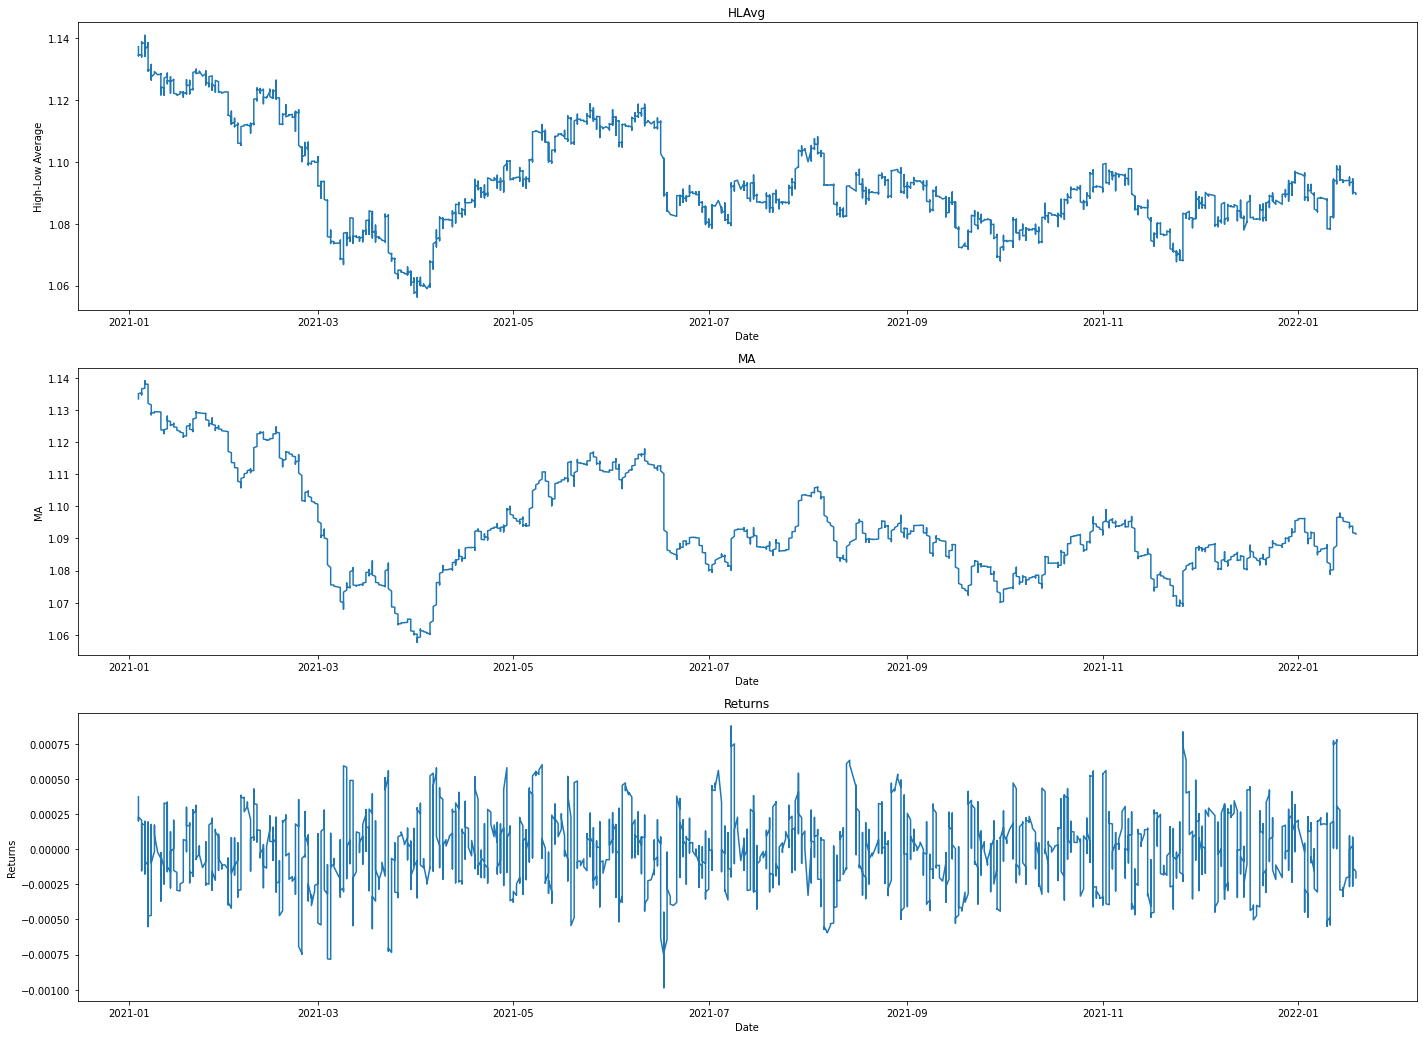

In [75]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date', ylabel='High-Low Average')
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date', ylabel='Returns')
ax3.plot(df['Returns'])

In [76]:
train_values = scaler.fit_transform(df[['Returns']].values)

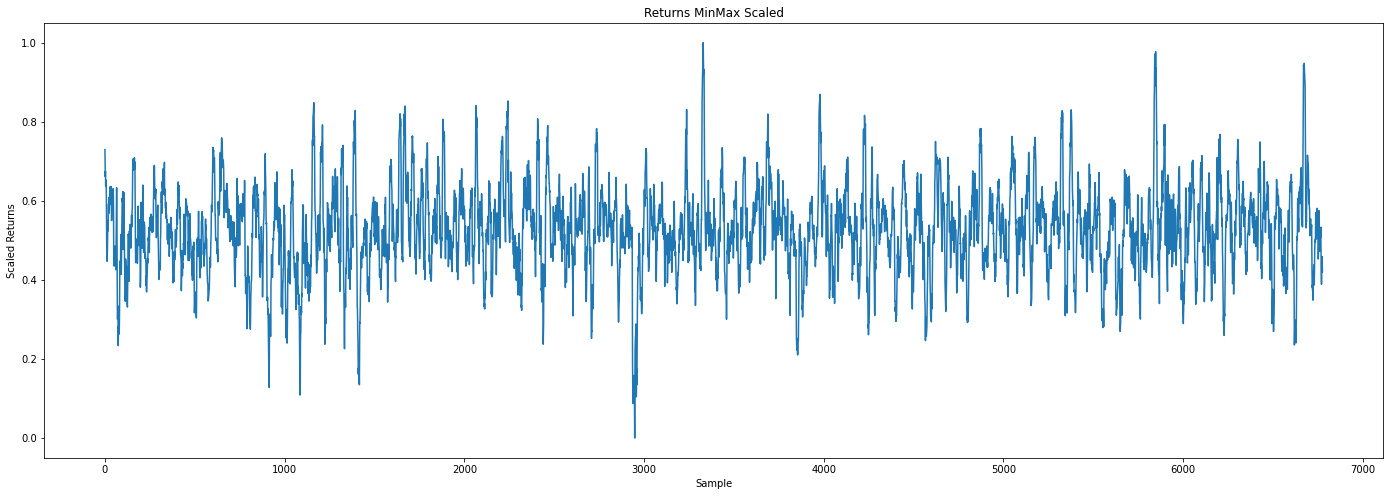

In [77]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [78]:
def get_train(values, window_size):
    X, y = [], []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
        y.append(values[i])
    X, y = np.asarray(X), np.asarray(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

def get_val(values, window_size):
    X = []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
    X = np.asarray(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = values[-X.shape[0]:]
    return X, y

In [79]:
X, y = get_train(train_values, xLen)

In [81]:
df_validation['Scaled'] = scaler.transform(df_validation[['Returns']].values)
X_val, y_val = get_val(df_validation['Scaled'].values, xLen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

In [85]:
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False)

Epoch 1/10
846/846 [==============================] - 11s 11ms/step - loss: 0.0080 - val_loss: 0.0030
Epoch 2/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 3/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 4/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 5/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0019 - val_loss: 9.7173e-04
Epoch 7/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 8/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 9/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0015 - val_loss: 9.1559e-04
Epoch 10/10
846/846 [==============================] - 8s 10ms/step - loss: 0.0014

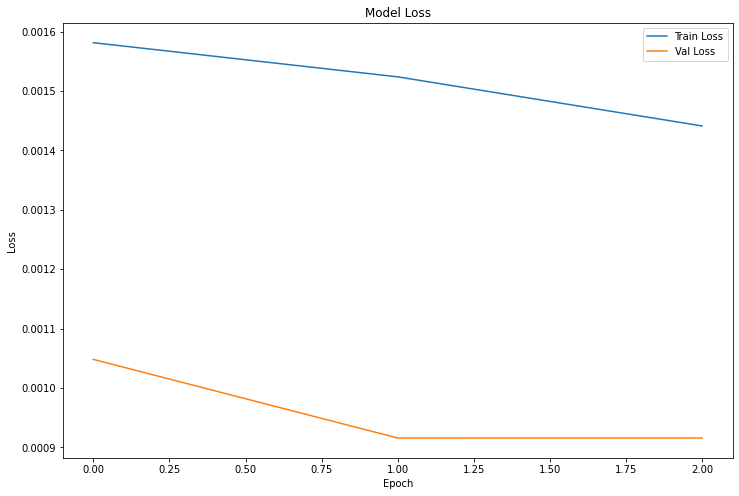

In [86]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()

In [87]:
df_test['Scaled'] = scaler.transform(df_test[['Returns']].values)
scaled = df_test['Scaled'].values
X = []
len_scaled = len(scaled)
for i in range(xLen, len_scaled):
    X.append(scaled[i-xLen:i])
X = np.asarray(X)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_true = scaled[-X.shape[0]:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
y_pred = model.predict(X)

In [89]:
df_test['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (xLen, 0), mode='constant', constant_values=np.nan)
df_test['Pred_Returns'] = scaler.inverse_transform(df_test[['Pred_Scaled']].values)
#df['Pred_MA'] = df["MA"].mul(1 + df['Pred_Returns'].shift(-1)).shift(1) # Arithmetic Returns
df_test['Pred_MA'] = df_test['MA'].mul(np.exp(df_test['Pred_Returns'].shift(-1))).shift(1) # Log Returns
df_test = df_test[xLen:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

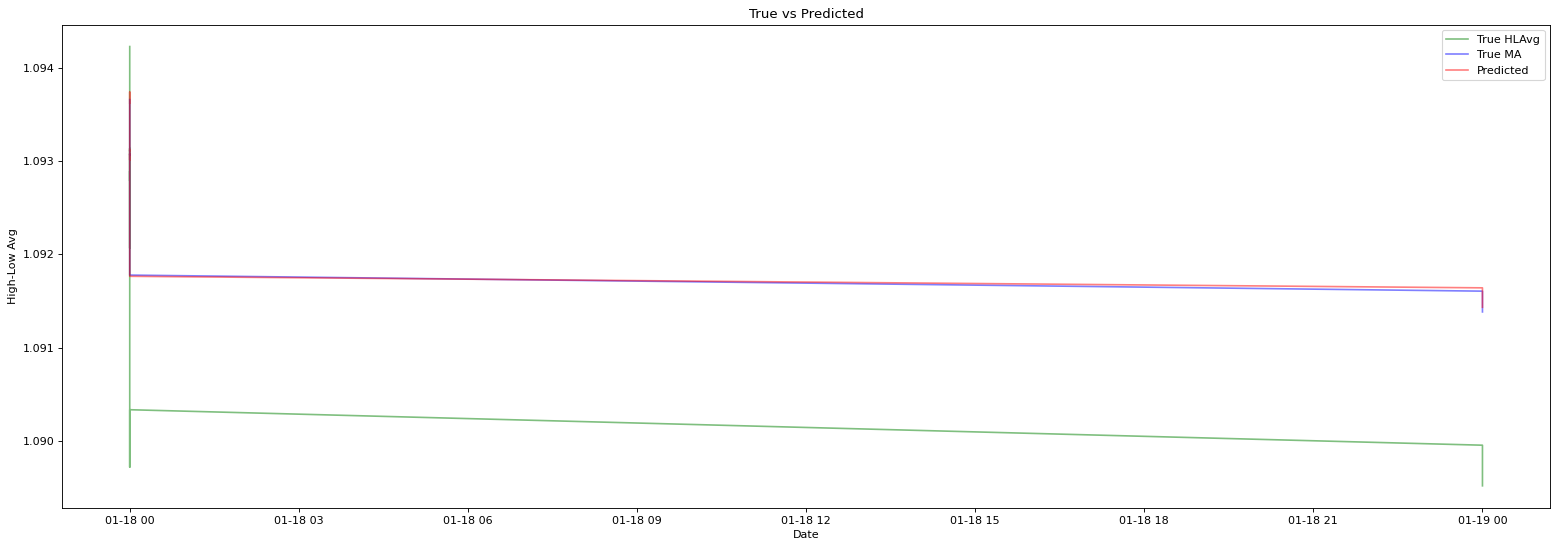

In [90]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_test['HLAvg'][-20:], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df_test['MA'][-20:], color = 'blue', label = 'True MA', alpha=0.5)
plt.plot(df_test['Pred_MA'][-20:], color = 'red', label = 'Predicted', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()

Общий итог:
- данные взяты на [сайте Финам](https://www.finam.ru/profile/forex/chf-usd/export/?market=5)
- файлы приложены к [репозиторию WildZes](https://github.com/WildZes/GeekUniversity_Ai/tree/master/NeuralNetworks_Intro)
- попытка 1 выполнялась на базе [репозитория AdamTibi](https://github.com/AdamTibi/LSTM-FX) и [материала урока](https://gbcdn.mrgcdn.ru/uploads/asset/3665580/attachment/05f3fe5ceb574821bedb0633553eab39.ipynb)
- для повторения попытки 1 требуется разкомментировать участок #sep=';', который находится в функции get_data (требуется в следствии наличия соответствующего сепаратора в одном из скачанных файлов)
- попытка 2 выполнена исключительно по образцу материала урока
- попытка 3 выполнена исключительно по образцу репозитория AdamTibi
- ни один из полученных результатов не готов использовать в системах прогнозирования рынка

### Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM

Для самостоятельной разработки архитектуры LSTM на numpy необходимые навыки, на данный момент отсутствуют.  
Воспользовался поисковиком для понимания как это может быть сделано и по найденому [материалу](https://christinakouridi.blog/2019/06/20/vanilla-lstm-numpy/) озадачился следующими вопросами:
- Кто и как создает архитектуры нейросетей?
- Сейчас и ранее встречалось, что оптимизатор ADAM является наиболее применимым. Какие еще примеры, с другими оптимизаторами, можно порекомендовать для понимания используемости оптимизатора относительно ситуации/данных/проекта/нейросети?
- Вопрос не по теме материалов, но по существу изучаемых материалов: насколько на рынке труда востребованы специалисты, которые способны собрать "кубики" различных нейронных сетей, но совсем незнакомые с содержанием этих "кубиков"?